In [162]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

In [163]:
#Loading up the Data
data = pd.read_csv(
    "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/01-03-2022.csv")


In [164]:
#Data Cleaning
data['Last_Update'] = pd.to_datetime(data['Last_Update'])
data['date'] = data['Last_Update'].dt.strftime('%m-%d-%Y')

In [165]:
#Feature Engineering
data['daily_cases'] = data['Confirmed'].diff().fillna(0)
data['rolling_avg'] = data['daily_cases'].rolling(window= 7).mean().fillna(0)

In [166]:
#Normalization
scaler = StandardScaler()
data[['daily_cases', 'rolling_avg']] = scaler.fit_transform(data[['daily_cases', 'rolling_avg']])

In [167]:
# Split into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Extract features for model training, excluding the 'date' column
train_data_for_model = train_data[['daily_cases', 'rolling_avg']]
test_data_for_model = test_data[['daily_cases', 'rolling_avg']]

In [171]:
#Building the Autoencoder
model = Sequential([
    Dense(32, activation='relu', input_shape=(train_data_for_model.shape[1],)),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(train_data_for_model.shape[1], activation='sigmoid')
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(train_data_for_model, train_data_for_model, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.0101 - val_loss: 0.3017
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 0.8958 - val_loss: 0.1733
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 0.6327 - val_loss: 0.1661
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 0.8281 - val_loss: 0.1645
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - loss: 1.3133 - val_loss: 0.1639
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 1.3577 - val_loss: 0.1634
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 0.5906 - val_loss: 0.1632
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 0.6311 - val_loss: 0.1630
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 0.9317 - val_loss: 0.1629
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 0.8844 - val_loss: 0.1627
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 1.1812 - val_loss: 0.1626
Epoch 12/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - l

In [173]:
# Predict the test set
test_data_prediction = model.predict(train_data_for_model)
# Calculate reconstruction error
r_error = np.mean(np.abs(train_data_for_model - test_data_prediction), axis=1)
# Set a threshold for anomalies
threshold = np.percentile(r_error, 95)
# Identify anomalies
test_data['reconstruction_error'] = r_error
test_data['anomaly'] = test_data['reconstruction_error'] > threshold

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


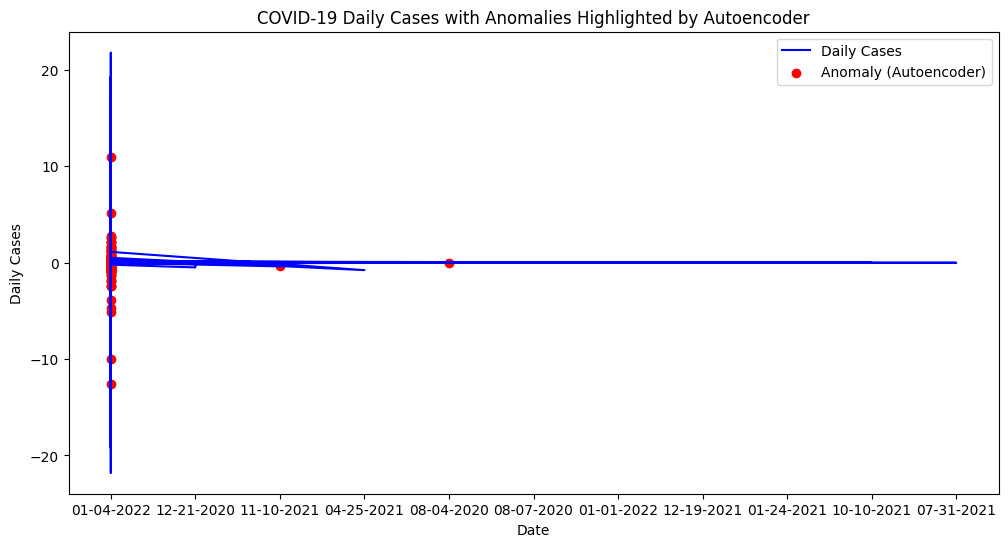

In [174]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['daily_cases'], label='Daily Cases', color='blue')
plt.scatter(test_data['date'], test_data['daily_cases'], color='red', label='Anomaly (Autoencoder)')
plt.xlabel('Date')
plt.ylabel('Daily Cases')
plt.title('COVID-19 Daily Cases with Anomalies Highlighted by Autoencoder')
plt.legend()
plt.show()